In [1]:
%pylab inline
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import pandas as pd
import mdtraj as md

Populating the interactive namespace from numpy and matplotlib


# coordinates

In [12]:
liganded_topfile = 'data/liganded_ca.pdb'
complex_topfile = 'data/complex_ca.pdb'
liganded_top = md.load(liganded_topfile)
complex_top = md.load(complex_topfile)
from glob import glob
liganded_list = glob('data/liganded/ca*.xtc')
complex_list = glob('data/complex100/ca*.xtc')

In [2]:
v1_2 = range(99,153)#top.topology.select('resi 99 to 152 and name CA')
b_sheet = list(range(89,92))+list(range(168,171))+list(range(385,387))+list(range(394,396))
#top.topology.select('resi 89 to 92 or resi 168 to 171 or resi 385 to 387 or resi 394 to 396 and name CA')
a1 = range(69,85)#top.topology.select('resi 69 to 85 and name CA')
v3 = range(265,294)#top.topology.select('resi 265 to 294 and name CA')

In [3]:
def compute_center_of_mass(traj,atom_indices=None):
    if atom_indices==None:
        atoms = traj.top.atoms
        coords = traj.xyz
    else:
        atoms = [traj.top.atom(i) for i in atom_indices]
        coords = np.take(traj.xyz, atom_indices, axis=1)
    com = np.zeros((traj.n_frames, 3))
    masses = np.array([a.element.mass for a in atoms])
    masses /= masses.sum()
    for i, x in enumerate(coords):
        com[i, :] = x.astype('float64').T.dot(masses)
    return com

In [4]:
def plot_angle(traj_files,top,ax,atom_indices1,atom_indices2,atom_indices3,name=''):
    from MDAnalysis.lib.distances import calc_angles
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)     
        angles = calc_angles(coords1,coords2,coords3)
        ax.plot(angles,label='{}{}'.format(name,i),lw=1,alpha=0.5)

In [5]:
def plot_distance(traj_files,top,ax,atom_indices1,atom_indices2,name=''):
    from MDAnalysis.lib.distances import calc_bonds
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)  
        coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
        coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
        distance = calc_bonds(coords1,coords2)
        ax.plot(distance,label='{}{}'.format(name,i),lw=1,alpha=0.5)

In [6]:
def plot_RMSD(traj_files,top,ax,name=''):
    for i,f in enumerate(traj_files):
        traj = md.load(f,top=top)
        rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
        ax.plot(rmsd,label='{}{}'.format(name,i),lw=1,alpha=0.5)

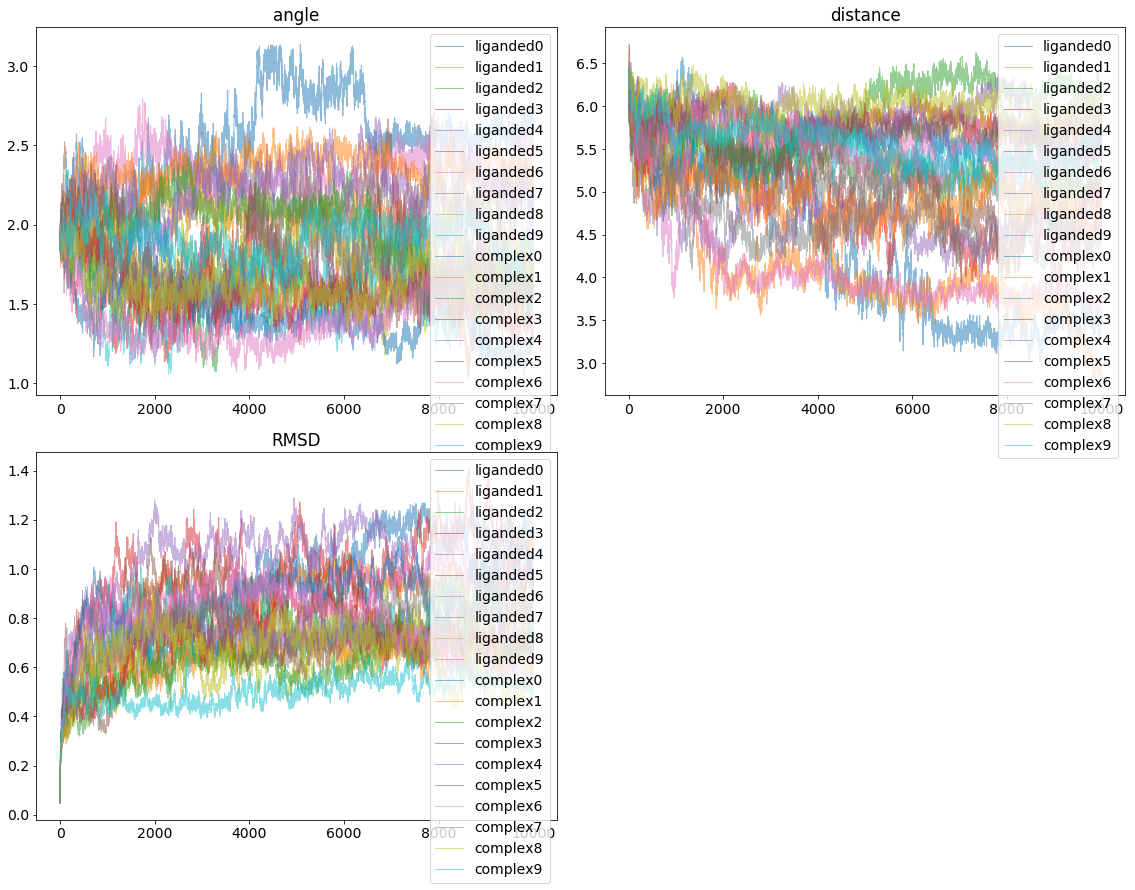

In [44]:
figure(figsize=(16,12))
subplot(221)
ax = gca()
plot_angle(liganded_list,liganded_top,ax,v1_2,b_sheet,a1,name='liganded')
plot_angle(complex_list,complex_top,ax,v1_2,b_sheet,a1,name='complex')
ax.legend()
title('angle')
subplot(222)
ax = gca()
plot_distance(liganded_list,liganded_top,ax,v1_2,v3,name='liganded')
plot_distance(complex_list,complex_top,ax,v1_2,v3,name='complex')
title('distance')
ax.legend()
subplot(223)
ax = gca()
plot_RMSD(liganded_list,liganded_top,ax,name='liganded')
plot_RMSD(complex_list,complex_top,ax,name='complex')
title('RMSD')
legend()
tight_layout()

In [7]:
def compute_angles(traj,atom_indices1,atom_indices2,atom_indices3,cossin=True):
    from MDAnalysis.lib.distances import calc_angles
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    coords3 = compute_center_of_mass(traj,atom_indices3).astype(np.float32)
    angles = calc_angles(coords1,coords2,coords3)
    #if cossin:
        #rad = np.dstack((np.cos(angles), np.sin(angles)))
        #rad = rad.reshape(rad.shape[0], rad.shape[1]*rad.shape[2])
    #else:
        #rad = angles
   # print rad
    return np.vstack(angles.astype(np.float32))#rad[0].astype(np.float32)

In [8]:
def compute_distance(traj,atom_indices1,atom_indices2):
    from MDAnalysis.lib.distances import calc_bonds
    coords1 = compute_center_of_mass(traj,atom_indices1).astype(np.float32)
    coords2 = compute_center_of_mass(traj,atom_indices2).astype(np.float32)
    distance = calc_bonds(coords1,coords2)
    return np.vstack(distance.astype(np.float32))

In [9]:
def RMSD(traj,top_file):
    top = md.load(top_file)
    rmsd = md.rmsd(traj.superpose(reference=top),reference=top)
    return np.vstack(rmsd.astype(np.float32))

In [10]:
def path_distance(traj,paths,top):
    paths_ca = [top.topology.residue(i).atom('CA').index for i in paths]
    pairs = [[paths_ca[i],paths_ca[i+1]] for i in range(len(paths_ca)-1)]
    distances = md.compute_distances(traj,pairs)
    return np.vstack(np.sum(distances,axis=1))

In [13]:
feat = coor.featurizer(liganded_topfile)
feat.add_custom_func(compute_angles,1,v1_2,b_sheet,a1)
#feat.add_custom_func(RMSD,1,liganded_topfile)
feat.add_custom_func(compute_distance,1,b_sheet,v3)

In [14]:
# complex_inp = coor.source(complex_list, complex_feat)
# liganded_inp = coor.source(liganded_list, liganded_feat)
# inp = coor.combine_sources([complex_inp,liganded_inp])
inp = coor.source(liganded_list+complex_list,feat)
data = inp.get_output()
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('trajectory time step = ',100.0 / (inp.trajectory_length(0)-1),'ns')
print('number of dimension = ',inp.dimension())

getting output of FeatureReader:   0%|          | 0/20 [00:00<?, ?it/s]/home/denglei/anaconda2/envs/python36/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'mock'
  warnings.warn(str(err))
100%|██████████| 20/20 [00:13<00:00,  1.49it/s]                                 

number of trajectories =  20
trajectory length =  10001
trajectory time step =  0.01 ns
number of dimension =  2


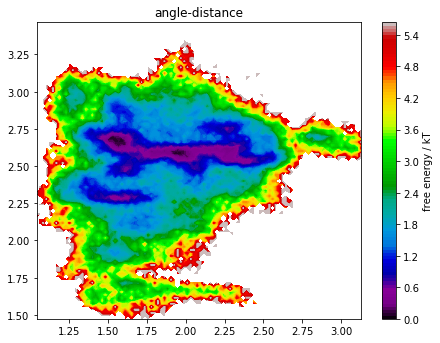

In [15]:
figure(figsize=(16,12))
subplot(221)
ax = gca()
mplt.plot_free_energy(np.vstack(data)[:,0], np.vstack(data)[:,1],ax=ax)
title('angle-distance')
# subplot(222)
# ax = gca()
# mplt.plot_free_energy(np.vstack(data)[:,2], np.vstack(data)[:,3],ax=ax)
# title('angle-RMSD')
# subplot(223)
# ax = gca()
# mplt.plot_free_energy(np.vstack(data)[:,1], np.vstack(data)[:,2],ax=ax)
# title('distance-RMSD')

# TICA

In [16]:
tica_obj = coor.tica(inp, lag=10, kinetic_map=True)
print('TICA dimension ', tica_obj.dimension())

100%|██████████| 20/20 [00:15<00:00,  1.35it/s]                       

TICA dimension  2


In [17]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

100%|██████████| 20/20 [00:14<00:00,  1.48it/s]                        

number of trajectories =  20
number of frames =  10001
number of dimensions =  2


(<matplotlib.figure.Figure at 0x7f5a65a72e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a490c3e48>)

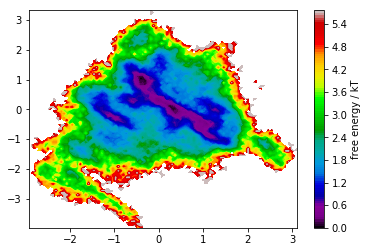

In [18]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])

([<matplotlib.axis.YTick at 0x7f59f3d074e0>,
 <a list of 4 Text yticklabel objects>)

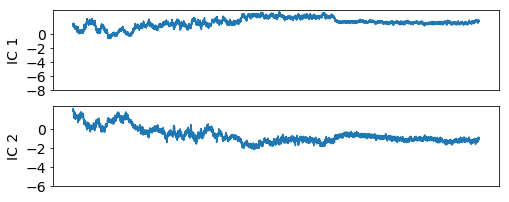

In [19]:
matplotlib.rcParams.update({'font.size': 14})
dt = 0.1
figure(figsize(8,5))
ax1=plt.subplot(311)
x = dt*np.arange(Y[0].shape[0])
plot(x, Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks(np.arange(-8, 2, 2))
ax1=plt.subplot(312)
plot(x, Y[0][:,1]); ylabel('IC 2'); xticks([]);  yticks(np.arange(-6, 2, 2))
#ax1=plt.subplot(313)
#plot(x, Y[0][:,2]); xlabel('time / ns'); ylabel('IC 3'); yticks(np.arange(-4, 2, 2))
#save_figure('ic_trajs.png')

# Clustering

In [21]:
n_clusters = 250
clustering = coor.cluster_kmeans(Y,k=n_clusters)


initialize kmeans++ centers:   0%|          | 0/250 [00:00<?, ?it/s]

initialize kmeans++ centers:  40%|████      | 100/250 [13:09<23:55,  9.57s/it]


initialize kmeans++ centers:  80%|███████▉  | 199/250 [27:15<05:08,  6.05s/it]


100%|██████████| 250/250 [35:19<00:00,  7.50s/it]                             

kmeans iterations: 100%|██████████| 10/10 [35:36<00:00, 87.10s/it]

28-09-18 16:56:49 pyemma.coordinates.clustering.kmeans.KmeansClustering[5] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.



100%|██████████| 10/10 [35:36<00:00, 87.10s/it]                   


In [22]:
dtrajs = clustering.dtrajs


100%|██████████| 20/20 [00:45<00:00,  3.44s/it]                                    


In [17]:
np.shape(dtrajs)

(20, 10001)

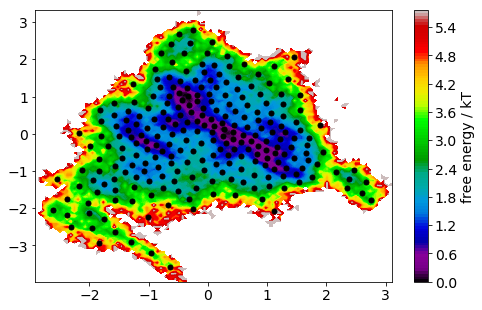

In [23]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

# Implied timescales

In [25]:
lags = range(0,100,5)
its = msm.timescales_msm(dtrajs, lags=lags, nits=20, errors='bayes', n_jobs=-1)


estimating BayesianMSM:   0%|          | 0/20 [00:00<?, ?it/s]

28-09-18 17:08:57 pyemma.msm.estimators.bayesian_msm.BayesianMSM[9] WARNING  Ignored error during estimation: row, column, and data array must all be the same length



100%|██████████| 20/20 [03:23<00:00, 12.86s/it]                        


28-09-18 17:12:20 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[10] WARNING  Estimation has failed at lagtimes: [0]. Details:
['Error at lag time 0: row, column, and data array must all be the same length']
28-09-18 17:13:47 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[10] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


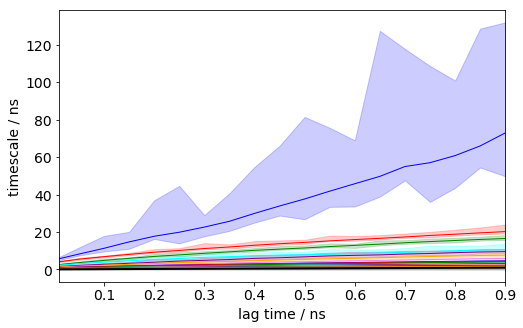

In [27]:
mplt.plot_implied_timescales(its, show_mean=False, ylog=False,  units='ns', linewidth=1,dt=0.01,)
#ylim(0,20000)


# Estimate MSM

In [28]:
msm_lag = 60
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)
print(M.nstates)

fraction of states used =  1.0
fraction of counts used =  1.0
250



100%|██████████| 9/9 [00:14<00:00,  1.18s/it]                                 


(<matplotlib.figure.Figure at 0x7f59d4b9db00>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59d4869b70>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f598c3954e0>]], dtype=object))

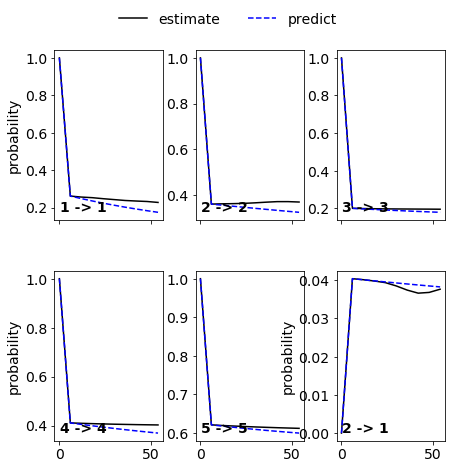

In [29]:
ck = M.cktest(5, mlags=10)

mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,3), padding_top=0.1, y01=False, padding_between=0.3, dt=0.01, units='ns')


# test MSM


SEJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdTYW1wbGluZyBNU01zJyksKSwgbGF5b3V0PUxheW91dChtYXhfd2lkdGg9dSczNSUnLCBtaW5fd2lkdGg9dSczNSXigKY=


SEJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oTGFiZWwodmFsdWU9dSdlc3RpbWF0aW5nIEJheWVzaWFuTVNNJyksKSwgbGF5b3V0PUxheW91dChtYXhfd2lkdGg9dSczNSUnLCBtaW5fd2nigKY=


(<Figure size 504x504 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a2e550950>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9a2e4db550>]], dtype=object))

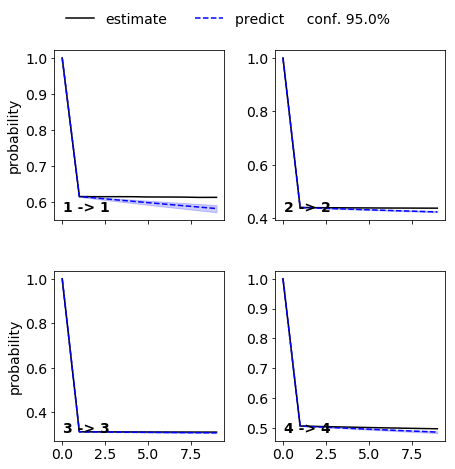

In [38]:
M = msm.bayesian_markov_model(dtrajs, msm_lag)
ck = M.cktest(4, mlags=10)
mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3, dt=0.1, units='step')

# Coarse-grained kinetic Model using a Hidden Markov Model

In [30]:
M.nstates

250

In [31]:
hmm = M.coarse_grain(5)

28-09-18 17:17:21 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[13] WARNING  Requested coarse-grained model with 5 metastable states at lag=60. The ratio of relaxation timescales between 5 and 6 states is only 1.1698432695524417 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


In [32]:
hmm.stationary_distribution 

array([ 0.22144816,  0.10823651,  0.20969225,  0.28983252,  0.17079056])

(<matplotlib.figure.Figure at 0x7f598c2a4668>,
 array([[ 0.52197269,  1.        ],
        [ 0.31268932,  0.        ],
        [ 0.41251003,  0.5011737 ],
        [ 0.        ,  0.33048914],
        [ 0.10285682,  0.82296691]]))

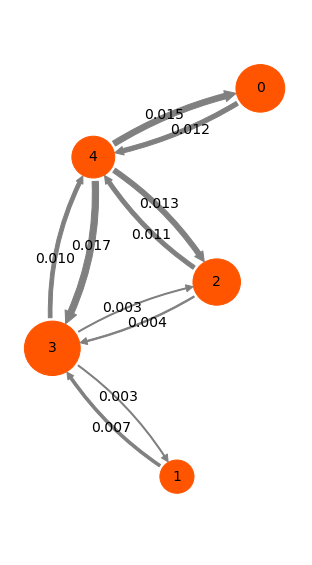

In [33]:
#pos=np.array([[-3, -4], [0, -5], [-4.2, 0.5], [0, 0]])
mplt.plot_markov_model(hmm, minflux=4e-4, arrow_label_format='%.3f',max_width=10, max_height=10)
